# SD212: Graph Learning
## Lab 6: Spectral Embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [5]:
dataset = karate_club(metadata=True)

In [6]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

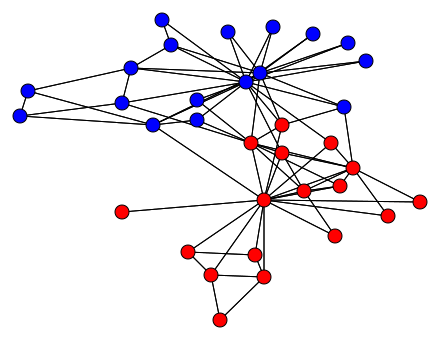

In [7]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first component of the embedding to the ground-truth clusters.

In [8]:
spectral = Spectral(20, normalized=False)

In [9]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

In [10]:
# eigenvalues (adding the first)
eigenvalues = [1] + list(spectral.eigenvalues_)

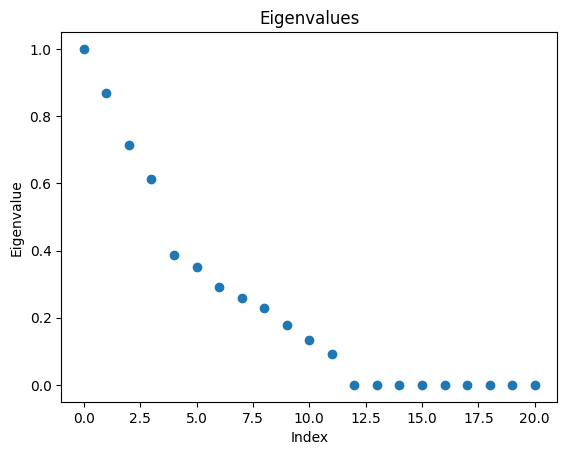

In [11]:
plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')
plt.show()

Three clusters.

In [12]:
# eigenvectors
eigenvectors = spectral.eigenvectors_

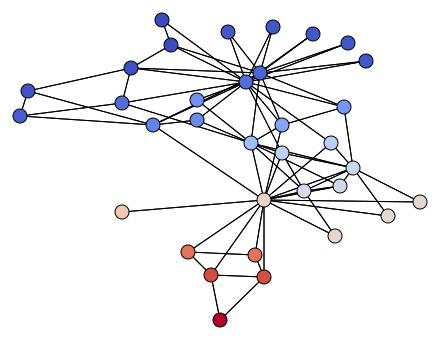

In [13]:
# display an eigenvector
image = visualize_graph(adjacency, position, scores=eigenvectors[:, 0])
SVG(image)

In [14]:
sign = lambda x: 1 if x > 0 else -1

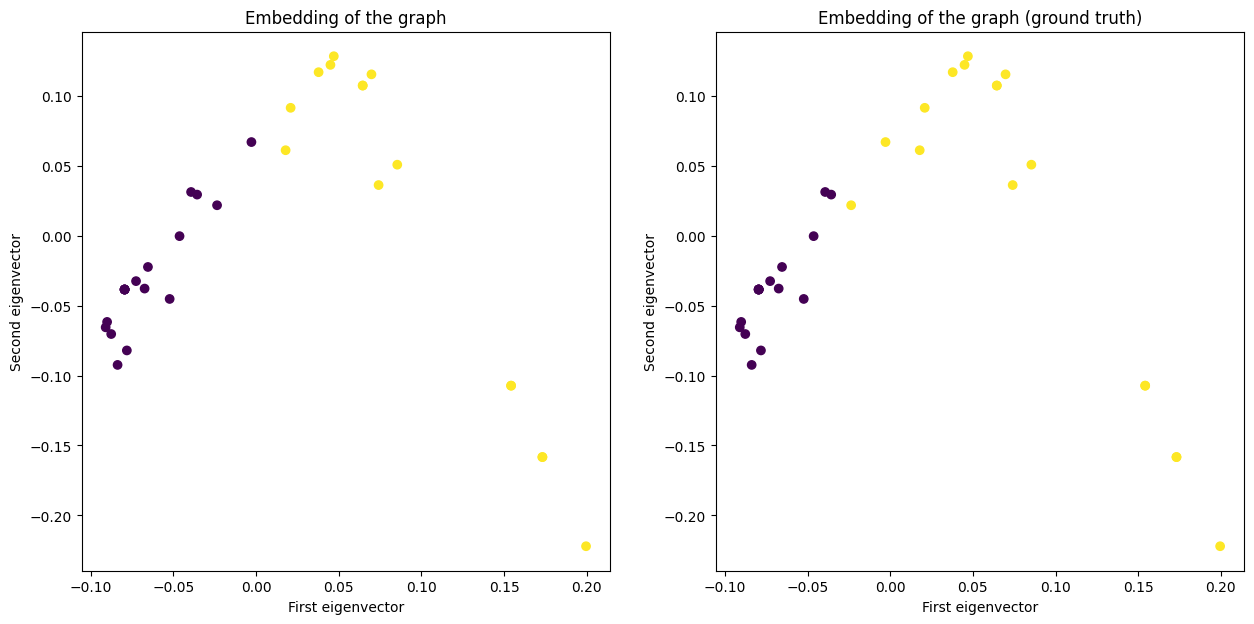

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].scatter(eigenvectors[:, 0], eigenvectors[:, 1], c=list(map(sign, eigenvectors[:, 0])))
axs[0].set_xlabel('First eigenvector')
axs[0].set_ylabel('Second eigenvector')
axs[0].set_title('Embedding of the graph')

axs[1].scatter(eigenvectors[:, 0], eigenvectors[:, 1], c=labels_true)
axs[1].set_xlabel('First eigenvector')
axs[1].set_ylabel('Second eigenvector')
axs[1].set_title('Embedding of the graph (ground truth)')

plt.show()

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [43]:
dataset = openflights

In [44]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

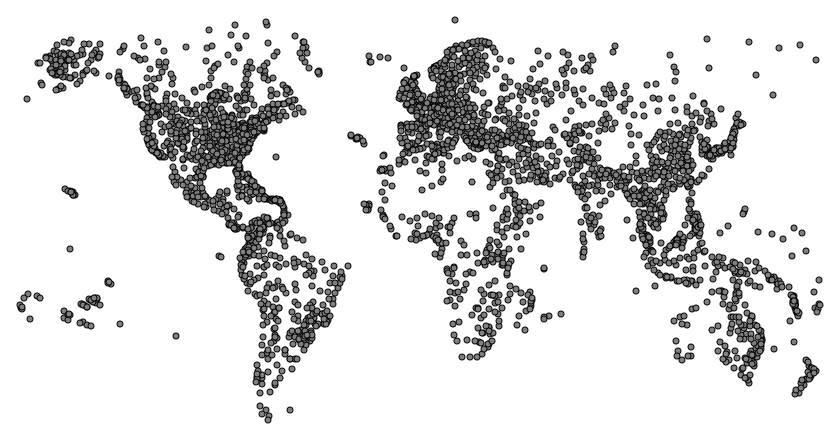

In [45]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. <br>**Hint:** Compute the distance of the centroid of each cluster to the origin in the embedding space.

In [46]:
spectral = Spectral(20, normalized=True)

In [47]:
embedding = spectral.fit_transform(adjacency)

In [48]:
image = visualize_graph(adjacency, position=embedding)
SVG(image)

In [49]:
from sknetwork.clustering import KCenters

kcenters = KCenters(n_clusters=8)
labels = kcenters.fit_predict(adjacency)

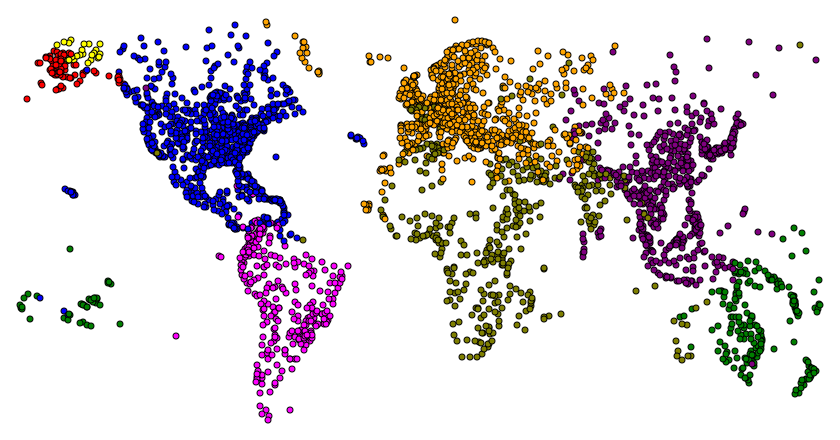

In [50]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=labels)
SVG(image)

In [57]:
# distance of the centroids to each clusters in the embedding space
centroids = kcenters.centers_
for i in range(8):
    print(f"Distance of centroid {i+1} to origin : {np.linalg.norm(embedding[centroids[i], :])}")

Distance of centroid 1 to origin : 1.0
Distance of centroid 2 to origin : 0.9999999999999997
Distance of centroid 3 to origin : 1.0
Distance of centroid 4 to origin : 0.9999999999999999
Distance of centroid 5 to origin : 0.9999999999999998
Distance of centroid 6 to origin : 1.0
Distance of centroid 7 to origin : 0.9999999999999998
Distance of centroid 8 to origin : 1.0


In [58]:
spectral = Spectral(20, normalized=False)
embedding = spectral.fit_transform(adjacency)
image = visualize_graph(adjacency, position=embedding)
SVG(image)

In [59]:
kcenters = KCenters(n_clusters=8)
labels = kcenters.fit_predict(adjacency)

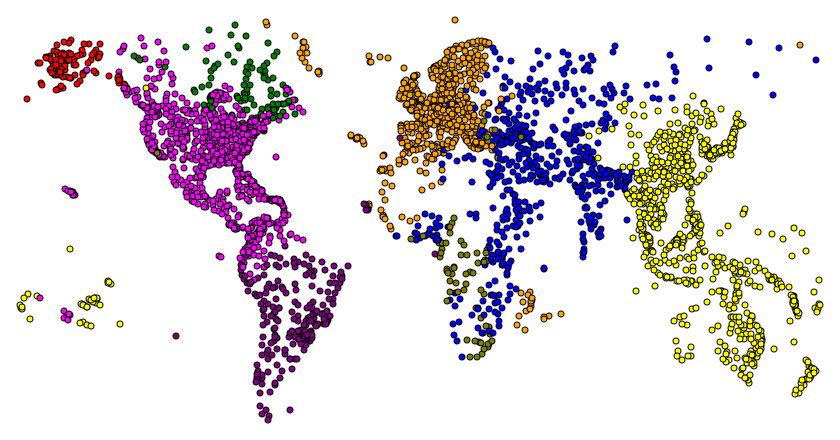

In [60]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=labels)
SVG(image)

In [61]:
# distance of the centroids to each clusters in the embedding space
centroids = kcenters.centers_
for i in range(8):
    print(f"Distance of centroid {i+1} to origin : {np.linalg.norm(embedding[centroids[i], :])}")

Distance of centroid 1 to origin : 0.0022407226929659027
Distance of centroid 2 to origin : 0.0891300535014603
Distance of centroid 3 to origin : 0.09320073057301165
Distance of centroid 4 to origin : 0.003130600109299259
Distance of centroid 5 to origin : 0.01504756461906575
Distance of centroid 6 to origin : 0.009640509131474193
Distance of centroid 7 to origin : 0.004227403173559816
Distance of centroid 8 to origin : 0.2774833528122903


## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in the embedding space in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we project the vectors on the unit sphere (``normalized=True``).

## Wikipedia Vitals

In [7]:
dataset = wikivitals

In [8]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the spectral embedding of the graph of links in dimension 20.

* List the 10 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space.
* Display the 3D-plot of each label in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the center of the corresponding articles, with a size proportional to the number of articles. Use ``plotly`` for an interactive plot.
* Display the dendrogram of the top-100 articles on **Arts** (in terms of Personalized PageRank) given by the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space (hierarchical clustering).

In [7]:
import plotly.express as px

In [5]:
from scipy.cluster.hierarchy import linkage

In [6]:
vvg = (names == 'Vincent van Gogh').nonzero()
assert len(vvg) == 1
vvg = vvg[0][0]

NameError: name 'names' is not defined

In [9]:
cosine_similarity = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [13]:
spectral = Spectral(20, normalized=True)
embedding = spectral.fit_transform(adjacency)
l = [0 * len(names_labels)]
c = [0* len(names_labels)]  
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            l[labels[i]] += cosine_similarity(embedding[i, :], embedding[j, :])
            c[labels[i]]+=1
for i in range(names_labels):
    print(f"{names_labels[i]}, {l[i]/c[i]}")

IndexError: list index out of range

In [11]:
spectral = Spectral(20, normalized=True)
embedding = spectral.fit_transform(adjacency)
cosines = [cosine_similarity(embedding[vvg, :], embedding[i, :]) for i in range(embedding.shape[0])]
top_articles = np.argsort(cosines)[::-1]
for i in range(10):
    print(f"Top {i+1} article : {names[top_articles[i]]}")

Top 1 article : Vincent van Gogh
Top 2 article : Georges Seurat
Top 3 article : Paul Cézanne
Top 4 article : Paul Gauguin
Top 5 article : Henri de Toulouse-Lautrec
Top 6 article : Franz Marc
Top 7 article : Post-Impressionism
Top 8 article : Edvard Munch
Top 9 article : Henri Rousseau
Top 10 article : Musée National d'Art Moderne


In [12]:
embedded_labels = [np.zeros(embedding.shape[1]) for _ in range(len(names_labels))]
for i, label in enumerate(labels):
    embedded_labels[label] = embedded_labels[label] + embedding[i, :]
embedded_labels = [embedded_labels[i] / (np.sum(labels == i)) for i in range(len(embedded_labels))]
embedded_labels = np.array(embedded_labels)
embedded_labels = embedded_labels[:, :3]
sizes = [np.sum(labels == i) for i in range(len(names_labels))]

In [15]:
# Create a DataFrame from the vectors and sizes
import pandas as pd
df = pd.DataFrame(embedded_labels, columns=['x', 'y', 'z'])
df['size'] = sizes
df['label'] = [names_labels[i] for i in range(len(embedded_labels))]

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', size='size', text='label', title="Labels embeddings")

# Update layout for better visualization
fig.update_traces(marker=dict(color='blue'), textposition='top center')
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Display the plot
fig.show()

## To do

* Repeat the same experiments on the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

## To do

* Prove that the average cosine similarity between nodes in some set $S$ is equal to the square distance of the barycenter of $S$ to the origin.

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality. 
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). 